# Estimating Education
#### Applied Machine Learning Final Project
#### Neal Bangerter and Amanda Marsden

*“We have one of the highest high school dropout rates of any industrialized nation… This is a
prescription for economic decline, because we know that the countries that out-teach us today will
out-compete us tomorrow… And dropping out of high school is no longer an option. It's not just
quitting on yourself, it's quitting on your country – and this country needs and values the talents of
every American”*

-President Barack Obama
State of the Union Speech to the US Congress,
February 24, 2009

### Problem Statement
Uncertainty surrounding the impact of educational inputs on educational
success measures (such as graduation rates, standardized test scores, and college enrollment
rates) limits the ability of public policy to effectively target areas for improvement. With this project, we aim to identify the school-level factors that most influence student success in public schools. The educational outcomes we examine are the proportion of students enrolling in 2 or 4 year colleges, the proportion of students enrolling in 4 year universities, the proportion of students who graduate in four years, the proportion of students who drop out each year, the proportion of students who take the SAT, and the average SAT score of students at a given school. These metrics are designed to give a relatively holistic view of a school's educational outcomes. Instead of using data for individuals, we've collected data aggregated on a school level, which we'll be using to corroborate previous research in the field that's primarily drawn from individual level effects. Instead of using this data to attempt to create a predictive model that would be of limited interest in this setting, we've opted to use machine learning techniques as a method for identifying the most impactful variables impacting each of the educational outcomes of interest.


### Getting the Data

We used data on public schools in Massachusetts collected by the Massachusetts Department of Elementary and Secondary Education and published in Statewide Reports. Below is the code used to read in and compile the files by year. We used data for the years 2008-2016, which had the most complete data available for our use. Each file was downloaded as individual CSVs (it was a nightmare, believe me), which we'll then compile into dataframes that include data for each school in each year.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LassoCV, SGDRegressor
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

These lists are used to iterate over the files I'll be reading in. "Files" refers to all the files that contain variables of interest, "years" is the years we have data on, "school_files" is the files with data at the school level, and "district_files" is files with data only at the district level.

In [2]:
files = ['apparticipation', 'apperformance', 'attendanceretention', 'attendingcollege', 
         'ClassSizebyGenPopulation', 'ClassSizebyRaceEthnicity', 'discipline', 'dropout', 
         'EducatorEvaluation', 'enrollmentbygrade', 'enrollmentbyracegender', 'enrollmentbyselectedpopulations', 
         'gradplans', 'gradrates', 'mcasresults', 'mobilityrates', 'PerPupilExpenditures', 'satperformance', 
         'staffingretentionrates', 'teacherbyracegender', 'teacherdata', 'TeacherSalaries']

years = ['2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']

school_files = ['apparticipation', 'apperformance', 'attendanceretention', 'attendingcollege', 
                'ClassSizebyRaceEthnicity', 'discipline', 'dropout', 'EducatorEvaluation', 'enrollmentbygrade', 
                'enrollmentbyracegender', 'gradplans', 'gradrates', 'mobilityrates', 'satperformance', 
                'teacherdata']

district_files = ['ClassSizebyGenPopulation', 'PerPupilExpenditures', 'TeacherSalaries']

This code creates a list called "schools", which we add to by iterating over every single year's data in each file and adding all the schools. School ID was used as the unique identifier, to simplify working with misspellings and such in the names. Then, all the duplicates were deleted out of schools to get a list of just the unique values, which was done because some schools were added/removed during the years 2008-2016, and some datasets were simply missing some schools.

As a note, we abuse try/except in the following code a lot. We know it's bad coding practice, but we used it to ease iterating over all the files since most of the datasets don't have data on all of the years. Rather than coding up a unique list of years for each dataset, we just used try/except to stop it from throwing an error.

In [3]:
schools = []

In [4]:
for file in school_files:
    for year in years:
        try:
            skip = 1
            if file == "enrollmentbyracegender":
                skip = 4
            if file == "teacherdata":
                skip = 2
            df = pd.read_excel("{}/{}.xlsx".format(file, year), skiprows=skip, dtype="object")
            for i in range(0,len(df)):
                schools.append(df.iloc[i,1])
        except:
            pass

In [5]:
temp = schools
schools = []

for school in temp:
    if school not in schools:
        schools.append(school)

Turn schools into a dataframe to make it easier to work with:

In [6]:
compiled = pd.DataFrame({'School':schools})

This dictionary is a list of each of the files and the columns of interest we'll be taking from each to use as variables in the analysis. Keys are the file names, and are tied to the corresponding lists of variables.

In [7]:
variables = {'apparticipation': ['Tests Takers', 'Tests Taken'], 
             'apperformance': ['% Score 3-5'], 
             'attendanceretention':['Retentions Rate', 'Attendance Rate', 'Average # of Absences', 
                                    'In-School Suspensions Rate', 'Out-of-School Suspensions Rate'], 
             'attendingcollege':['Attending Coll./Univ. (%)'], 
             'ClassSizebyGenPopulation':['Average Class Size', 'English Language Learner %', 
                                         'Students with Disabilities %', 'Economically Disadvantaged %'], 
             'ClassSizebyRaceEthnicity':[], 
             'discipline':['Students Disciplined'], 
             'dropout':['% Dropout All Grades'], 
             'EducatorEvaluation':['% Evaluated', '% Exemplary', '% Proficient', '% Needs Improvement', 
                                   '% Unsatisfactory'], 
             'enrollmentbygrade':['Total', '9', '10', '11', '12'], 
             'enrollmentbyracegender':['African American', 'Asian', 'Hispanic', 'White', 'Native American', 
                                       'Males'],
             'gradplans':['4 Year Private College', '4 Year Public College', '2 Year Private College', 
                          '2 Year Public College'], 
             'gradrates':['% Graduated', '% Still in School', '% Non-Grad Completers', '% H.S. Equiv.', 
                          '% Dropped Out'],
             'mobilityrates':['% Churn', '% Intake', '% Stability'], 
             'PerPupilExpenditures':['In-District Expenditures per Pupil', 'Total Expenditures per Pupil'], 
             'satperformance':['Tests Taken', 'Reading', 'Writing', 'Math'],
             'teacherdata':['% of Teachers Licensed in Teaching Assignment', 
                            '% of Core Academic Classes Taught by Teachers Who are Highly Qualified', 
                            'Student/Teacher Ratio'], 
             'TeacherSalaries':['Average Salary']}

For clarity, we've included the following explanation of each variable we use in our model:

1. **Tests Takers:** The proportion of students who are taking AP tests. 
2. **Tests Taken_x:** The average number of AP tests taken per person.
3. **% Score 3-5:** The proportion of students who recieve a 3-5 score on their AP exams. 
4. **Students Disciplined:** The proportion of students disciplined in each school. 
5. **% Droupout All Grades:** The proportion of students within a school that droupout in a given year. 
6. **% Evaluated:** The proportion of teachers whose performance is evaluated by the district. 
7. **% Exemplary:** The proportion of teachers that recieved an "exemplary" performance review. 
8. **% Proficient:** The proportion of teachers that recieved a "proficient" performance review. 
9. **% Needs Improvement:** The proportion of teachers that recieved a "needs improvement" performance review. 
10. **% Unsatisfactory:** The proportion of teachers that recieved an "unsatisfactory" performance review. 
11. **Total:** Total number of students. 
12. **9:** Number of students in 9th grade. 
13. **10:** Number of students in 10th grade. 
14. **11:** Number of students in 11th grade. 
15. **12:** Number of students in 12th grade. 
16. **4 Year Private College:** Proportion of students who will be attending a 4 year private college post gradation. 
17. **4 Year Public College:** Proportion of students who will be attending a 4 year Public college post gradation. 
18. **2 Year Private College:** Proportion of students who will be attending a 2 year private college post gradation. 
19. **2 Year Public College:** Proportion of students who will be attending a 4 year private college post gradation. 
20. **% Graduated:** Proportion of students who graduated in 4 years or less. 
21. **% Still in School:** Pr
22. **% Non-Grad Completers:**
23. **% H.S. Equiv.:** 
24. **% Dropped Out:**
25. **% Churn:**
26. **% Intake:**
27. **% Stability:**
28. **Tests Taken_y:** The average number of SAT tests taken per person.
29. **Reading:** Average reading standardized test score. 
30. **Writing:** Average writing standardized test score. 
31. **Math:** Average math standardized test score. 
32. **% of Teachers Licensed in Teaching Assignment:** Proportion of teachers who are licensed in their assigned subject. 
33. **% of Core Academic Classes Taught by Teachers Who are Highly Qualified:** Proportion of core classes taught by highly qualified teachers. 
34. **Student/Teacher Ratio:** The number of students attending the school divided by the number of teachers working at the school. 
34. **District:** The district code. 
35. **Average Class Size:** The average number of students per class. 
36. **English Language Learner %:** The proportion of the school that qualifies as an English language learner which is someone who's English proficiency is below that of their grade level. 
37. **Students with Disabilities %:** The proportion of the students that have disabilities. 
38. **Economically Disadvantaged %:** The proportion of the student body who participate in any state-level program targeting low-income families or students, such as reduced-price lunches. 
39. **In-District Expenditures per Pupil:** All of a district's operating expenditures for in-district programs divided by the average enrollment across the school year for pupils enrolled at local schools. 
40. **Toatal Expenditures per** All district operating expenditures for in-district programs and out-of-district placements divided by the average enrollment across the school year for pupils enrolled at local schools. 
41. **Average Salary:** Teachng salaries divided by the number of full-time equivalent teachers in each school.

Further along, we'll engineer some of the features to better indicate the factors we're attempting to measure.

To ease iteration, we decided to store the data for each year in a dictionary, with each year being a key in the dictionary with a corresponding dataframe of all the data for that year:

In [8]:
data_dict = {}

for year in years:
    data_dict["{}".format(year)] = compiled

Now the fun part: reading in the data. This bit of code iterates over all the files for all the years, and concatenates it with the corresponding dataframe in the data_dict dictionary:

In [9]:
for year in years:
    for file in school_files:
        try:
            # some of the files had irregular headers, which meant I needed to skip variable numbers of rows.
            skip = 1
            if file == "enrollmentbyracegender":
                skip = 4
            if file == "teacherdata":
                skip = 2
            
            # read in Excel file
            df = pd.read_excel("{}/{}.xlsx".format(file, year), skiprows=skip, dtype="object")
            
            # get only the variables of interest and the school id
            df = pd.concat([df[variables[file]], df.iloc[:,1]], axis=1)
            
            # rename the school id column to ensure that the merge works
            df.rename(columns = {list(df)[-1]: 'School'}, inplace = True)
            
            # merge with the corresponding dataframe
            data_dict[year] = pd.merge(data_dict[year], df, on='School', how='left')
            
        except:
            pass

### Data Cleaning

To visualize the missing values, we used the missingno library, created by Bilogur and available here: https://github.com/ResidentMario/missingno

Text(0.5,1.4,'Missing Values, 2016')

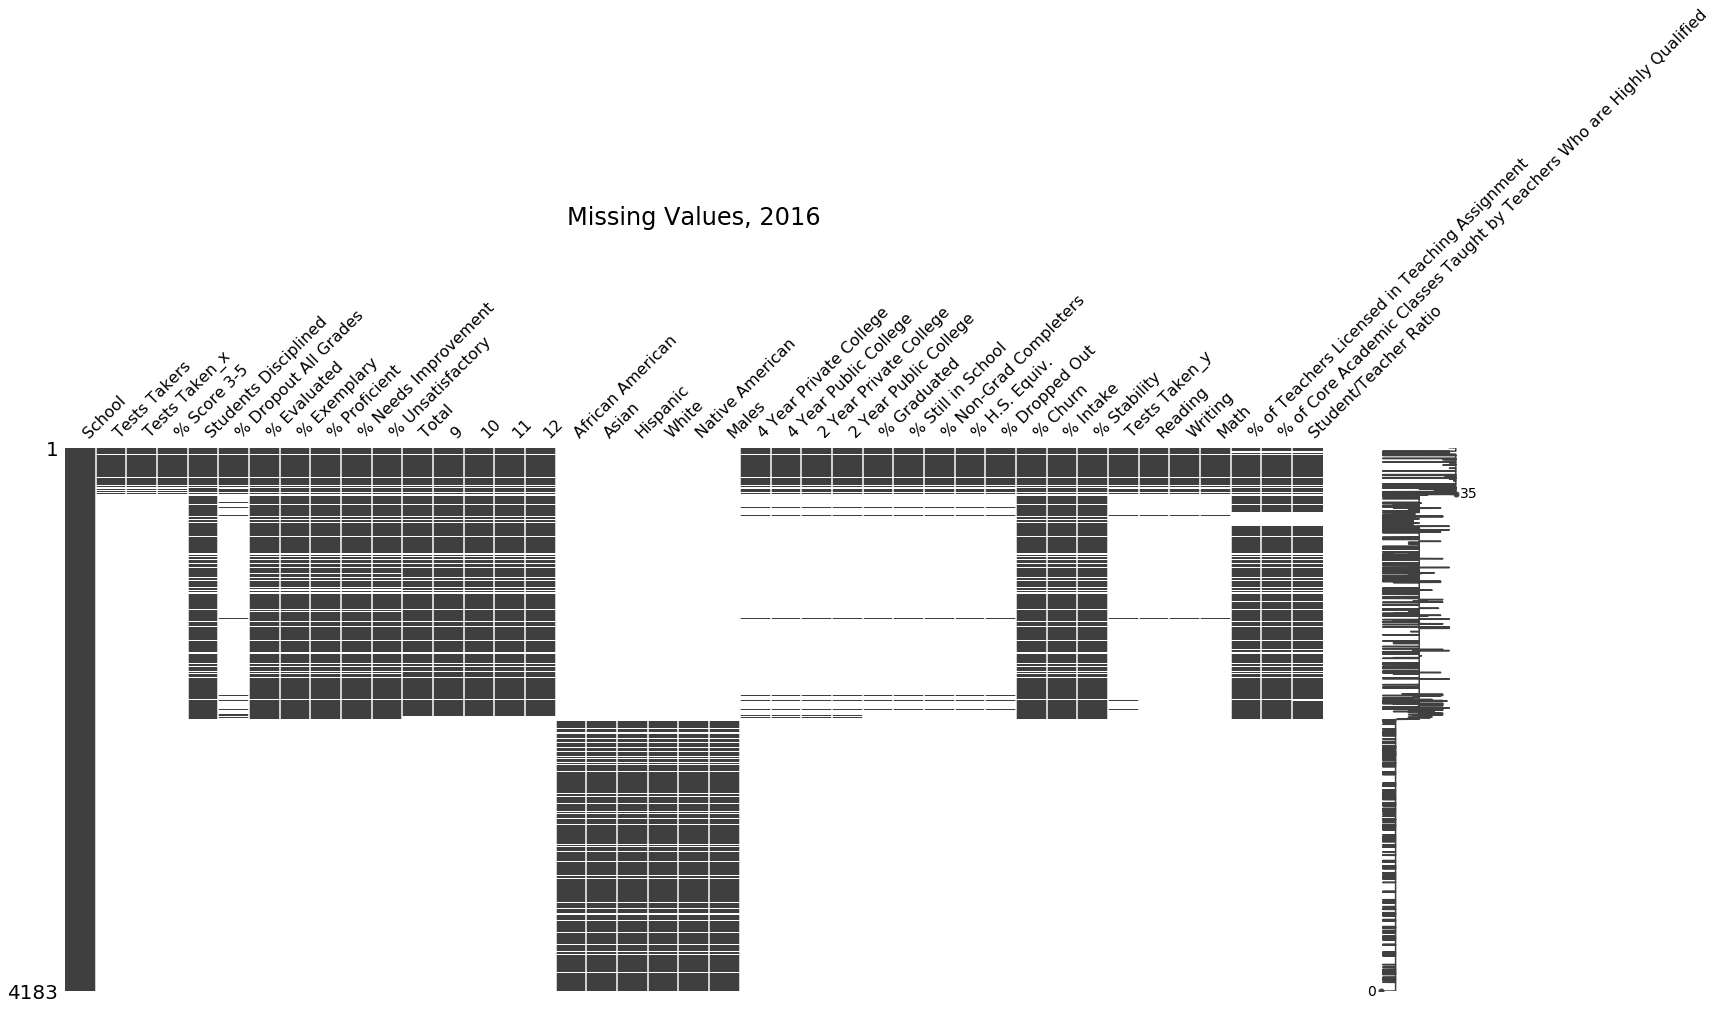

In [10]:
msno.matrix(data_dict['2016'])
plt.title("Missing Values, 2016", fontsize=24, y=1.4)

That's not good. Unfortunately, it looks like the school ID labels were inconsistent for the demographic data. There wasn't anyway to determine which schools they actually applied to, so we were forced to remove demographic information from the data, which was a pretty unfortunate loss. Also, most of the schools in the dataset aren't high schools, which means we can't use their data in our analysis since we're focusing on outcomes out of high school. There wasn't any data on the type of school included, but "4 Year Private College" appeared to have values for all the schools that we identified as high schools, didn't have values for any non-high schools, and didn't have any other missing values, so we used this column to proxy whether the school was a high school or not, and dropped all rows that had a null value here.

Here's the code to delete out the mis-indexed information, and remove the non-high schools:

In [11]:
for year in years:
    # drop mis-indexed variables
    data_dict[year] = data_dict[year].drop(['African American', 'Asian', 'Hispanic', 'White', 'Native American', 
                                            'Males'], axis=1)
    try:
        # '4 Year Private College' is a proxy for whether a school is a high school or not
        data_dict[year] = data_dict[year][pd.notnull(data_dict[year]['4 Year Private College'])]
    except:
        pass

Text(0.5,1.4,'Missing Values, 2016')

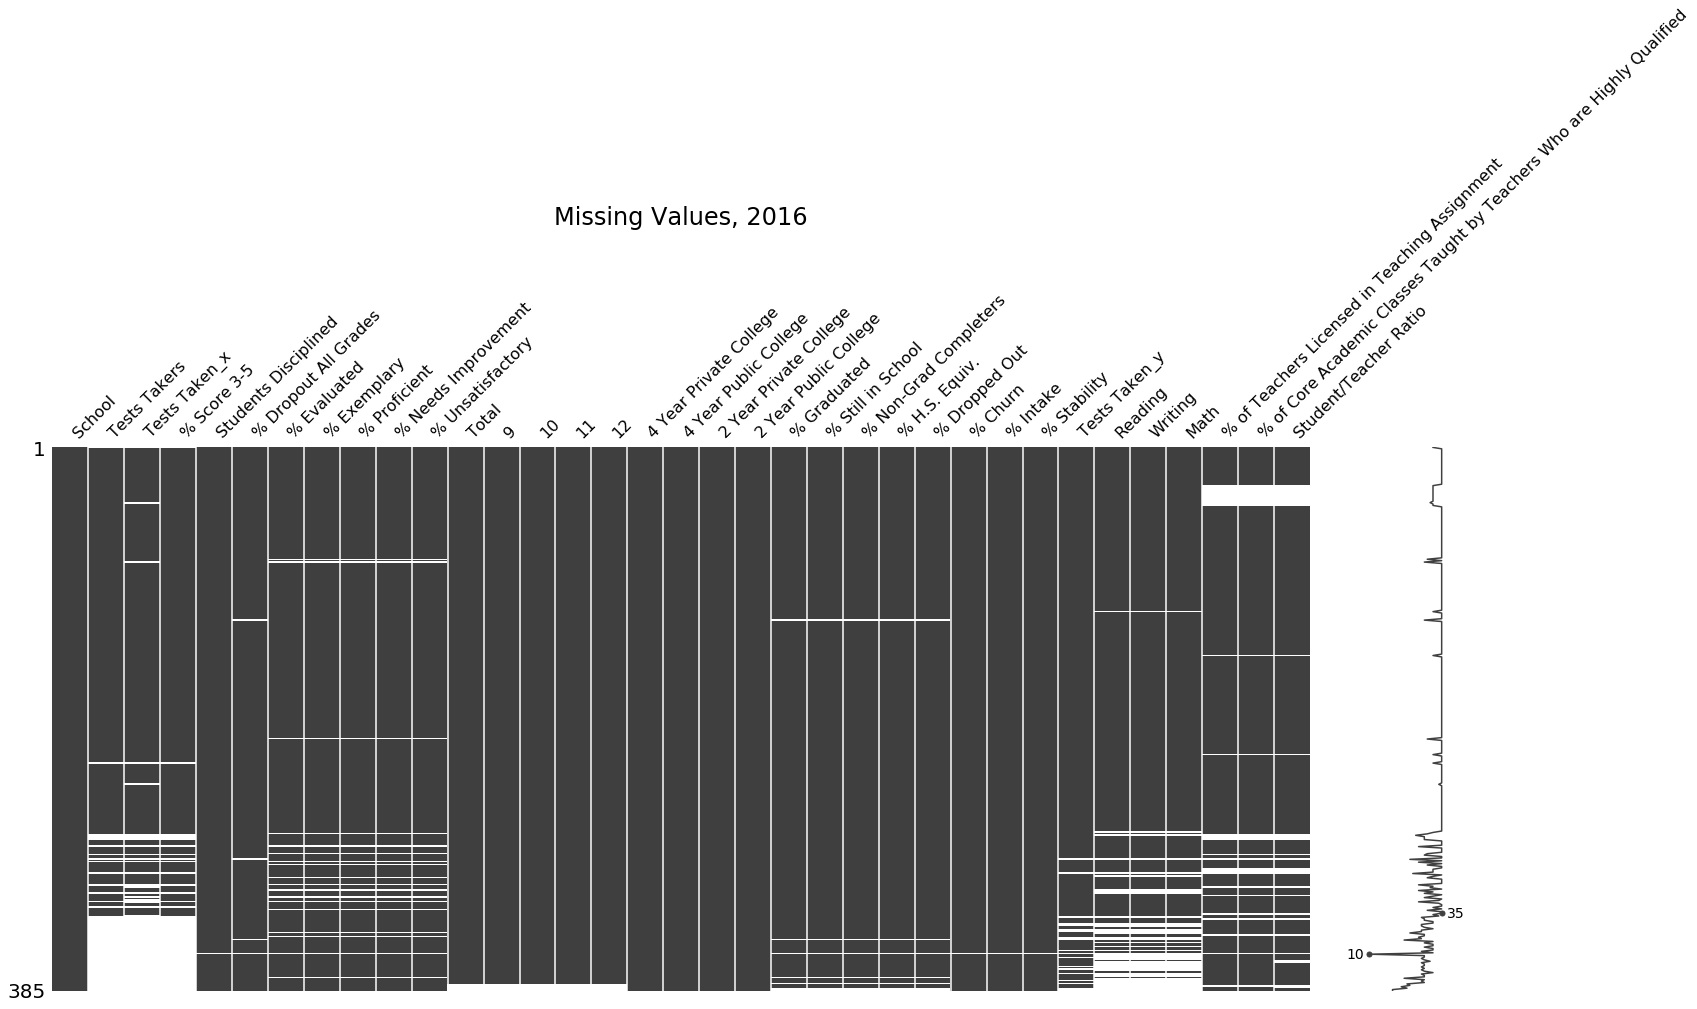

In [12]:
msno.matrix(data_dict['2016'])
plt.title("Missing Values, 2016", fontsize=24, y=1.4)

Charting the data again, it looks like we're in much better shape. There are still a lot of missing values, but it looks like we've got a reasonable number of data for each year (between 300 and 400 schools), without too many values missing for anyone school. We'll impute missing data a bit later, but first we'll read in the district data.

Reading in the district-level data for each school required a bit of feature engineering. The first four characters in the school code were the non-zero characters in the district code, so we used that to link the two.

In [13]:
for year in years:
    # reset the index after we dropped the rows earlier
    data_dict[year] = data_dict[year].reset_index(drop=True)
    
    # create a district variable and populate it with the correct code
    data_dict[year]['District'] = None
    
    for i in range(0,len(data_dict[year])):
        data_dict[year]['District'][i] = data_dict[year]['School'][i][0:4] + "0000"

This is the code that read in and merged the proper district-level information:

In [14]:
for year in years:
    for file in district_files:
        try:
            skip = 1
                
            df = pd.read_excel("{}/{}.xlsx".format(file, year), skiprows=skip, dtype="object")
            
            df = pd.concat([df[variables[file]], df.iloc[:,1]], axis=1)

            df.rename(columns = {list(df)[-1]: 'District'}, inplace = True)
            
            data_dict[year] = pd.merge(data_dict[year], df, on='District', how='left')
            
        except:
            pass

Now for feature engineering! A couple of the values aren't in the numeric format we need, so we'll parse through and get them in the format we need. Student/Teacher Ratio includes an unnecessary "to 1" on the end of every ratio, so we'll just parse through and get the number. Similarly, some of the values had commas, 15 spaces at the beginning of each value (they really didn't even bother making the data easy to work with), and $ symbols, so we just replaced all of those with nothing to leave only the numbers.

In [15]:
for year in years:
    for i in range(0,len(data_dict[year])):
        try:
            data_dict[year]['Student/Teacher Ratio'][i] = data_dict[year]['Student/Teacher Ratio'][i].split(' ', 1)[0]
        except:
            pass

In [16]:
for year in years:
    data_dict[year] = data_dict[year].replace(['\$', ' ', ','],'', regex=True)

Now that all the data was pushed into a numeric format, we can convert it from an object data type to a numeric data type. Errors were coerced to be null because the excel files used non-standard ways of representing nulls, such as asterisks.

In [17]:
for year in years:
    for file in files:
        try:
            for variable in variables[file]:
                data_dict[year][variable] = pd.to_numeric(data_dict[year][variable], errors='coerce')
                
        except:
            pass    

Since we had two 'Tests Taken' variables, one corresponding to AP tests and one to SAT tests, the columns were renamed with an x and a y on the end, so we'll have to make those numeric manually:

In [18]:
for year in years:
    try:
        data_dict[year]['Tests Taken_x'] = pd.to_numeric(data_dict[year]['Tests Taken_x'])
        data_dict[year]['Tests Taken_y'] = pd.to_numeric(data_dict[year]['Tests Taken_y'])
    except:
        pass

### Feature Engineering and Preliminary Data Visualization

Some of our data isn't in a form that will be usable for analysis. 'Total' refers to the total number of students, but some of the high schools included students from younger grades, so we recalculated the 'Total' number of students to refer to only students in high school years (grades 9 to 12). 'Tests Takers' gave a number of students instead of a proportion, so it was converted to a proportion by dividing by the total number of students.

We also created new outcome variables for some of the effects we were interested in examining. '% 4 Year' and '% 2 or 4 Year' are the percent of students from a given high school who enroll in the corresponding sorts of upper education. 'Average SAT Score' is the total score of the schools' averages on each section of the SAT, and '% of students taken SAT' is a measure of the proportion of students who took the SAT in a given year at a given school.

In [19]:
for year in years:
    data_dict[year]['Total'] = data_dict[year]['9'] + data_dict[year]['10'] + data_dict[year]['11'] + data_dict[year]['12']
    data_dict[year]['Tests Takers'] = data_dict[year]['Tests Takers'] / data_dict[year]['Total']
    data_dict[year]['% 4 Year'] = data_dict[year]['4 Year Private College'] + data_dict[year]['4 Year Public College'] 
    data_dict[year]['% 2 or 4 Year'] = data_dict[year]['2 Year Private College'] + data_dict[year]['2 Year Public College'] + data_dict[year]['% 4 Year']  
    data_dict[year]['Average SAT Score'] = data_dict[year]['Reading'] + data_dict[year]['Writing'] + data_dict[year]['Math']
    data_dict[year]['% of students taking SAT'] = data_dict[year]['Tests Taken_y'] / data_dict[year]['Total']

For charting purposes further along, we'll want a non-scaled version of our data without the imputed values:

In [20]:
data_dict_not_scaled = data_dict

For every column in our data, it made sense to fill the missing values with the column's mean:

In [21]:
for year in years:
    for col in list(data_dict[year]):
        data_dict[year].loc[data_dict[year][col].isnull(),col] = data_dict[year][col].mean()

Since not all the variables were available for all the years, it was necessary to make a list of the dependent and independent variables we'd be using for each year. 2008-2010 had the same data available, as did 2011-2012, and 2013-2016. These six lists are the corresponding lists of variables:

In [22]:
independent_variables_2008_2010 = ['Tests Takers', '% Score 3-5', 'Retentions Rate', 'Attendance Rate', 
                                   'Average # of Absences', 'In-School Suspensions Rate', 
                                   'Out-of-School Suspensions Rate', 'Total', '% Churn', '% Intake', 
                                   '% Stability', 'Tests Taken_y', '% of Teachers Licensed in Teaching Assignment', 
                                   '% of Core Academic Classes Taught by Teachers Who are Highly Qualified', 
                                   'Student/Teacher Ratio', 'In-District Expenditures per Pupil', 
                                   'Total Expenditures per Pupil', 'Average Salary']
dependent_variables_2008_2010 = ['% 4 Year', '% 2 or 4 Year', 'Average SAT Score', '% of students taking SAT', 
                                 '% Dropped Out', '% Graduated']

In [23]:
independent_variables_2011_2012 = ['Tests Takers', '% Score 3-5', 'Retentions Rate', 'Attendance Rate', 
                                   'Average # of Absences', 'In-School Suspensions Rate', 
                                   'Out-of-School Suspensions Rate', 'Total', '% Churn', '% Intake', 
                                   '% Stability', 'Tests Taken_y', '% of Teachers Licensed in Teaching Assignment', 
                                   '% of Core Academic Classes Taught by Teachers Who are Highly Qualified', 
                                   'Student/Teacher Ratio', 'In-District Expenditures per Pupil', 
                                   'Total Expenditures per Pupil', 'Average Salary', 'Average Class Size', 
                                   'English Language Learner %', 'Students with Disabilities %', 
                                   'Economically Disadvantaged %']
dependent_variables_2011_2012 = ['% 4 Year', '% 2 or 4 Year', 'Average SAT Score', '% of students taking SAT', 
                                 '% Dropped Out', '% Graduated']

In [24]:
independent_variables_2013_2016 = ['Tests Takers', '% Score 3-5', 'Total', '% Churn', '% Intake', '% Stability', 
                                   'Tests Taken_y', '% of Teachers Licensed in Teaching Assignment', 
                                   '% of Core Academic Classes Taught by Teachers Who are Highly Qualified', 
                                   'Student/Teacher Ratio', 'In-District Expenditures per Pupil', 
                                   'Total Expenditures per Pupil', 'Average Salary', 'Average Class Size', 
                                   'English Language Learner %', 'Students with Disabilities %', 
                                   'Economically Disadvantaged %', '% Exemplary', '% Proficient', 
                                   '% Needs Improvement', '% Unsatisfactory']
dependent_variables_2013_2016 = ['% 4 Year', '% 2 or 4 Year', 'Average SAT Score', '% of students taking SAT', 
                                 '% Dropped Out', '% Graduated']

In order to get a feel for the outcome variables, we've charted some of their distributions from 2016 below as a sample. Data for other years is pretty comparable to the data shown here. 

Text(0.5,1.05,'% 4 Year Distribution')

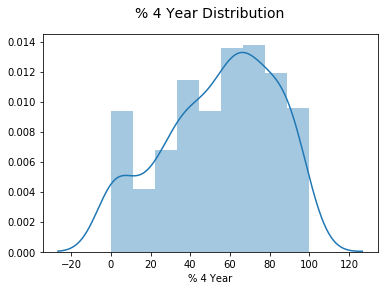

In [25]:
sns.distplot(data_dict_not_scaled['2016']['% 4 Year'])
plt.title('% 4 Year Distribution', size=14, y=1.05)

There's an enormous amount of variation in the percent of students going on to attend four year universities. Most high schools have very high levels of college enrollment, but there are also quite a few with strikingly low levels of enrollment, which should hopefully make this an interesting outcome to look at.

Text(0.5,1.05,'Average SAT Score Distribution')

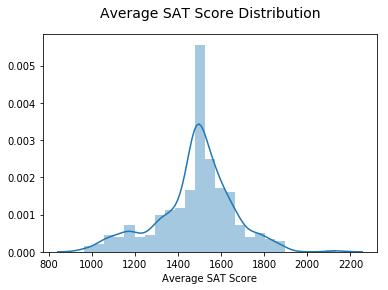

In [26]:
sns.distplot(data_dict_not_scaled['2016']['Average SAT Score'])
plt.title('Average SAT Score Distribution', size=14, y=1.05)

Average SAT Score looks about like what you would expect: a large lump in the middle with relatively long tails, indicating high achieving and low achieving schools.

Text(0.5,1.05,'% Graduated Distribution')

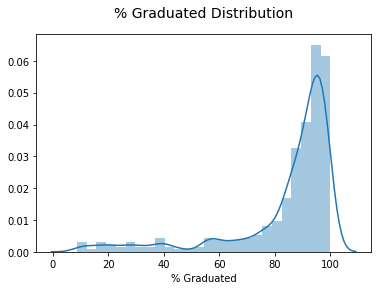

In [27]:
sns.distplot(data_dict_not_scaled['2016']['% Graduated'])
plt.title('% Graduated Distribution', size=14, y=1.05)

It looks like on the % Graduated, we have a heavily right-skewed distribution, with the vast majority of schools graduating nearly all their students in four years.

Beyond simply looking at distribution, correlation with other variables will be integral to our analysis:

Text(0.5,1.05,'Correlation Matrix Heatmap - Top 8, % Graduated')

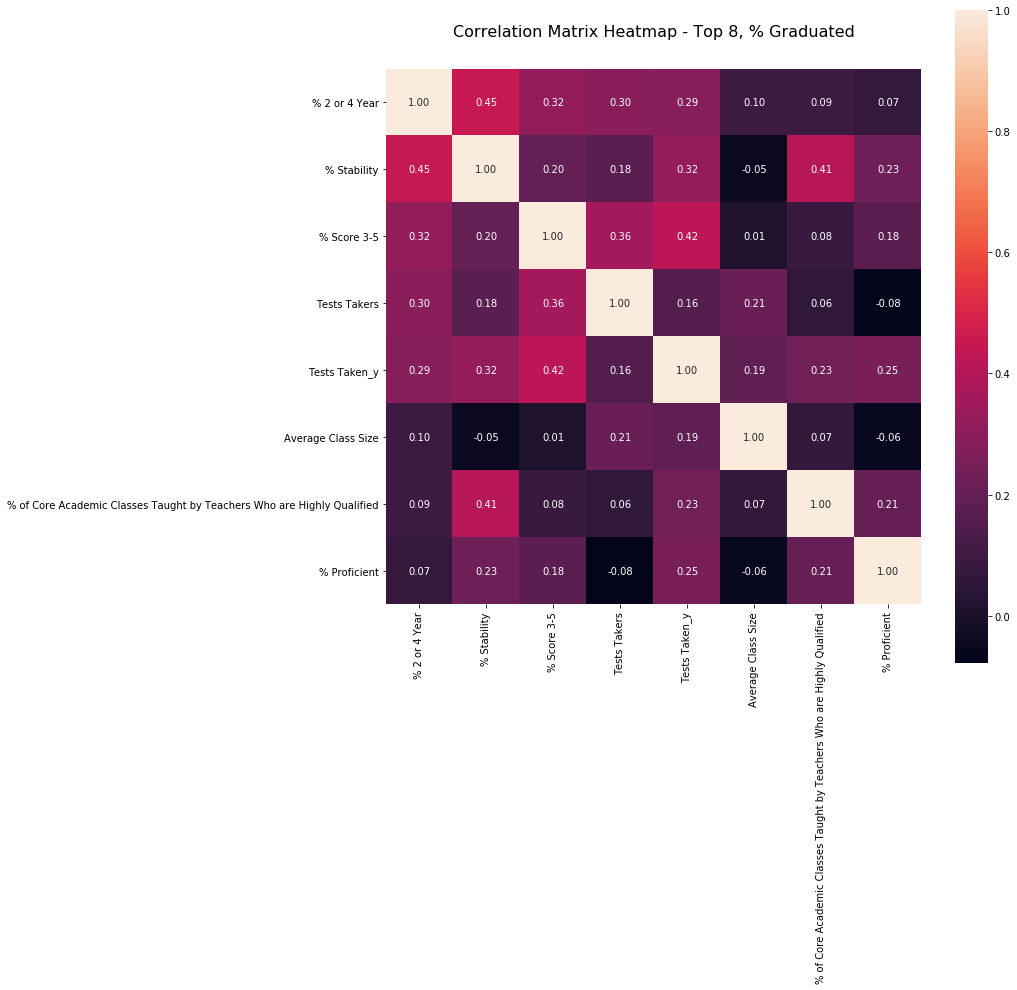

In [28]:
cols = independent_variables_2013_2016
cols.append('% 2 or 4 Year')
cols = (data_dict['2016'][cols]).corr().nlargest(8, '% 2 or 4 Year')['% 2 or 4 Year'].index
top_corr = np.corrcoef(data_dict['2016'][cols].values.T)

plt.subplots(figsize = (12,12))
sns.heatmap(top_corr, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
            yticklabels=cols.values, xticklabels=cols.values)
plt.title('Correlation Matrix Heatmap - Top 8, % Graduated', fontsize=16, y=1.05)

It looks like we have a pretty solid set of variables that correlate highly with our dependent variables. We've only included one correlation matrix for brevity's sake, but each of the other dependendent variables has similarly strong correlation matrices, with many overlapping values. Again, correlation levels look relatively constant between years included in our analysis.

Since each year has different variables available, we couldn't scale all the data using the same scaler, so I defined a function to scale the data using a standard scaler, that I then called on each year's dataframe.

In [29]:
def scale(df):
    df = df.drop(['School','District'], axis=1)
    scaler = StandardScaler()
    scaler.fit(df)
    scaler.transform(df)
    return df

In [30]:
for year in years:
    data_dict[year] = scale(data_dict[year])

### Using Models to Identify the Most Important Factors

The first model we attempted to use to find the most important factors for each educational outcome was a regression with l1 regularization (Lasso). Unfortunately, it proved to not be terribly useful, with most of the coefficients getting pushed to zero, and failed to be at all robust in cross-validation. The code we used to print out the variables with non-zero coefficients for each independent variable in each year is commented out below.

In [31]:
def train_lasso(year, dependent):
    # set the independent variable list to be used
    if year == '2008' or year == '2009' or year == '2010':
        independent_variables = independent_variables_2008_2010

    if year == '2011' or year == '2012':
        independent_variables = independent_variables_2011_2012

    if year == '2013' or year == '2014' or year == '2015' or year == '2016':
        independent_variables = independent_variables_2013_2016

    # split data in to training and target    
    train = data_dict[year][independent_variables]
    target = data_dict[year][dependent]
    
    # use a grid search to identify the best level for alpha
    lasso = LassoCV(alphas=[0.1,1,10,100,500,1000], max_iter=1000000)
    
    # fit the model using the best hyper parameters
    lasso.fit(train, target)
    
    # print out the variables with non-zero coefficients
    for x, y in enumerate(train.columns):
        if abs(lasso.coef_[x]) != 0.0:
            print(y + ":", lasso.coef_[x])

In [32]:
#for year in years:
#    if year == '2008' or year == '2009' or year == '2010':
#        dependent_variables = dependent_variables_2008_2010
#
#    if year == '2011' or year == '2012':
#        dependent_variables = dependent_variables_2011_2012
#
#    if year == '2013' or year == '2014' or year == '2015' or year == '2016':
#        dependent_variables = dependent_variables_2013_2016
#   
#    for var in dependent_variables:
#        print(year, var + ':')
#        train_lasso(year, var)
#        print('\n')

The next model we used to identify the most important features was a random forest. This proved significantly more robust than the random forest. While it overfit quite a bit in some cases (achieved far lower accuracy for testing data than training data), the predictions of the most important variables were incredibly robust between years, with nearly identical predictions. This involved calculating a couple hundred random forests which took quite a while and printed an enormous mess, so we've commented out that code and included examples of what we generally found, and we'll discuss and summarize what we learned below.

In order to predict continuous values (which all of our dependent variables were), we tried dividing the data into both quartiles and deciles. The training accuracy fell significantly between the quartiles and the deciles for most of the year and dependent variable combinations, but, curiously, the testing accuracy had a smaller decline, even though you'd expect it to get significantly worse since it's predicting ten categories instead of four. The most important variables identified were robust between estimating quartiles and deciles, so we've left the code below as estimating quartiles.

In [33]:
def train_random_forest(year, dependent, params):
    # selects the correct set of independent variables
    if year == '2008' or year == '2009' or year == '2010':
        independent_variables = independent_variables_2008_2010

    if year == '2011' or year == '2012':
        independent_variables = independent_variables_2011_2012

    if year == '2013' or year == '2014' or year == '2015' or year == '2016':
        independent_variables = independent_variables_2013_2016
    
    train = data_dict[year][independent_variables]
    target = pd.qcut(data_dict[year][dependent], 4, labels=False) # the four here indicates we're cutting into quartiles
    
    # train test split
    X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.33, random_state=42)
    
    # builds a random forest using the parameters it was passed
    random_forest = RandomForestClassifier(n_estimators=params[0], max_depth=params[1], class_weight=params[2])
    
    random_forest.fit(X_train, y_train)
    
    train_predictions = random_forest.predict(X_train)
    test_predictions = random_forest.predict(X_test)
    
    # finds the relatively most important features for the given random forest
    feature_imp = sorted(list(zip(independent_variables, random_forest.feature_importances_)), 
                         key=lambda x: x[1], reverse=True)
    
    # prints the training and testing accuracy, as well as the five features that were found to be most important
    print("{} - {}:".format(year,dependent))
    print("Training Accuracy:", accuracy_score(y_train, train_predictions))
    print("Testing Accuracy:", accuracy_score(y_test, test_predictions))
    print("Top 5 Features:")
    for i in range(0,5):
        print(feature_imp[i])

In [34]:
# This function finds the best hyper-parameters for the random forest with the given year and dependent variable
# It performs a grid search, so it takes a little while to run, but gave us the most robust results.
def get_params(year, dependent):
    if year == '2008' or year == '2009' or year == '2010':
        independent_variables = independent_variables_2008_2010

    if year == '2011' or year == '2012':
        independent_variables = independent_variables_2011_2012

    if year == '2013' or year == '2014' or year == '2015' or year == '2016':
        independent_variables = independent_variables_2013_2016
    
    train = data_dict[year][independent_variables]
    target = pd.qcut(data_dict[year][dependent], 10, labels=False)
    
    X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.33, random_state=42)
    
    n_estimators = [1000, 2500, 5000]
    max_depth = [1, 3, 5, 10]
    class_weights = ['balanced', None]
    best_accuracy = 0

    # code for the grid search
    for est in n_estimators:
        for depth in max_depth:
            for wgt in class_weights:
                clf = RandomForestClassifier(n_estimators=est, max_depth=depth, oob_score=True, class_weight=wgt)
                clf.fit(X_train, y_train)
                testing_predictions = clf.predict(X_test)
                accuracy = accuracy_score(y_test, testing_predictions)
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = (est, depth, wgt)
                    
    return best_params

In [35]:
#for year in years:
#    if year == '2008' or year == '2009' or year == '2010':
#        dependent_variables = dependent_variables_2008_2010
#
#    if year == '2011' or year == '2012':
#        dependent_variables = dependent_variables_2011_2012
#
#    if year == '2013' or year == '2014' or year == '2015' or year == '2016':
#        dependent_variables = dependent_variables_2013_2016
#        
#    for var in dependent_variables:
#        params = get_params(year, var)
#        train_random_forest(year, var, params)
#        print('\n')

In [36]:
year='2016'
var='Average SAT Score'

params = get_params(year, var)
train_random_forest(year, var, params)

2016 - Average SAT Score:
Training Accuracy: 0.910505836576
Testing Accuracy: 0.6875
Top 5 Features:
('Economically Disadvantaged %', 0.16706609716624532)
('% Score 3-5', 0.14738205745257207)
('% Stability', 0.070283923876232293)
('% Churn', 0.069235780982747588)
('English Language Learner %', 0.063860631739017903)


In [37]:
year='2013'
var='Average SAT Score'

params = get_params(year, var)
train_random_forest(year, var, params)

2013 - Average SAT Score:
Training Accuracy: 1.0
Testing Accuracy: 0.75
Top 5 Features:
('% Score 3-5', 0.13640309680016235)
('Economically Disadvantaged %', 0.13328886453357125)
('% 2 or 4 Year', 0.091316818838893407)
('% Stability', 0.061175426328189488)
('% Churn', 0.054623855695992075)


### Conclusions and Analysis

Proportion of economically disadvantaged students proved to be far and away the most important indicator, swamping every other predictor of educational outcomes. For every single dependent variable and every single year for which data was available on economic disadvantage, the proportion of economically disadvantaged students was in the top five most important features, and more often than not ranked first. This holds with current literature and research on factors effecting education; nearly all research indicates that socioeconomic status is the most important predictor of educational attainment, which then dampens the impact of efforts aimed at changing students' trajectories.

The next most important variable was found to be the three measures of enrollment stability: stability, churn, and intake, and was a particularly strong indicator of graduation and dropout rates. This would seem to indicate that, in general, students perform better at a single school, but could also be indicative of unobserved factors, such as financial instability in the home, forcing students' families to move. 

Out of keeping with economic literature on the subject, teacher quality was not found to be terribly important. This is likely due to the poor data included in the dataset: principles and administrators ranked nearly all teachers as exemplary, which wasn't very helpful. Similarly, there wasn't much variation in the percent of licensed teachers or the percent of classes taught by highly proficient teachers, making it difficult to gauge its impact. With better data, and not aggregated at a school level, it would be easier to measure the impact teacher quality has on student learning.

Other variables were more closely tied to the value being predicted: % of students scoring between 3 and 5 on AP exams (passing the exams) was a very strong predictor of SAT performance, which makes sense, but also isn't terribly useful, as it represents correlation more than any sort of causal relationship. It's likely that both students' scores on AP tests and the SAT are influenced by the school's ability to prepare students for standardized tests, making the relationship between the two relatively meaningless.

Text(0.5,0,'% Economically Disadvanted')

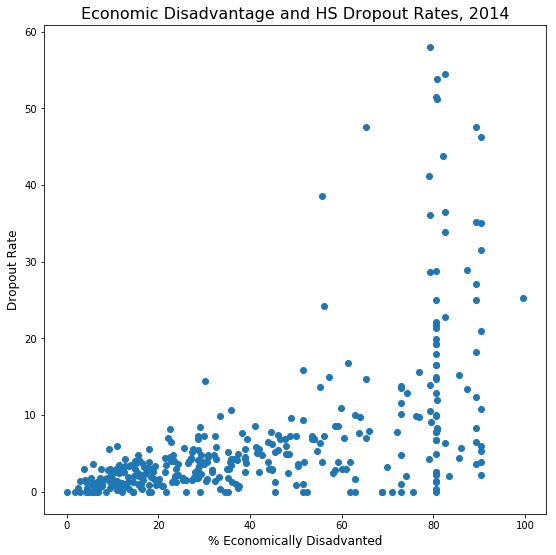

In [38]:
plt.subplots(figsize=(9,9))
plt.scatter(data_dict_not_scaled['2014']['Economically Disadvantaged %'], 
            data_dict_not_scaled['2014']['% Dropped Out'])
plt.title('Economic Disadvantage and HS Dropout Rates, 2014', fontsize=16)
plt.ylabel('Dropout Rate', fontsize=12)
plt.xlabel('% Economically Disadvanted', fontsize=12)

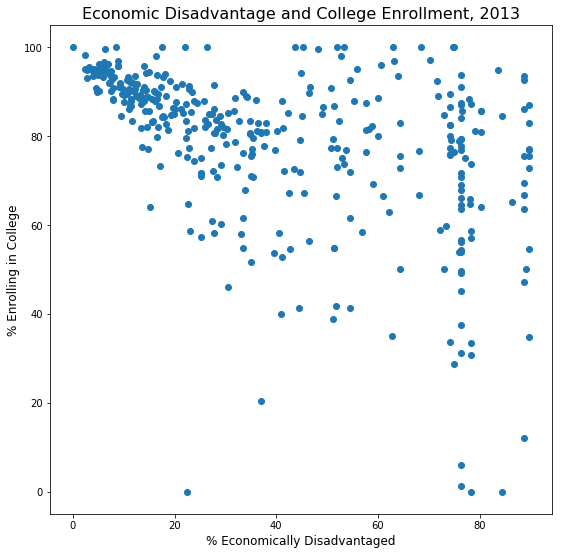

In [39]:
plt.subplots(figsize=(9,9))
plt.scatter(data_dict_not_scaled['2013']['Economically Disadvantaged %'], 
            data_dict_not_scaled['2013']['% 2 or 4 Year'])
plt.title('Economic Disadvantage and College Enrollment, 2013', fontsize=16)
plt.ylabel('% Enrolling in College', fontsize=12)
plt.xlabel('% Economically Disadvantaged', fontsize=12)
plt.xlim=(0,40)

Upon finding this, we decided to drill down deeper into the variables that were identified as most important. The above charts show the relationship between Economic Disadvantage and the Dropout Rate and Economic Disadvantage and College Enrollment rates for two different years. Data for different years and with different dependent variables looks similar. What's immediately striking from the two charts is the presence of heteroskedasticity: while schools with low levels of economic disadvantage have pretty uniformly low dropout rates, there's significantly more variance at higher proportions of economic disadvantage. This variance isn't entirely explained by other variables in our model. This may be indicative of a school's ability to influence better outcomes for students, regardless of the economic situation faced by a student's families. Our dataset doesn't have the scope necessary to more fully investigate this relationship, but further research on this topic should definitely look to address the high level of variance in the educational outcomes of schools with high proportions of economically disadvantaged students.

Our project is a little odd in that it isn't overtly concerned with prediction. The differences in variance could likely be addressed with a boosting model to better predict incorrect predictions and improve the accuracy of predictions, but predicting a school's educational outcomes with the quantity of variables we've used here doesn't seem terribly useful or interesting.

In conclusion, economic disadvantage proved to be overwhelmingly important in predicting education outcomes. Other factors, such as teacher quality, spending on students, and the student/teacher ratio were important when economic disadvantage was excluded from the models, but that predictive value vanished and was largely contained in differences in economic disadvantage, all of which is in keeping with economic theory on the topic. By using machine learning techniques, we were able to corroborate previous findings in this area of research using only school-level data, and with a high level of robust-ness; while it would be difficult to use our methods to determine causality or measure the precise impact of any variables on educational outcomes, similar methods could be used to inform more compilcated models designed to tease out causal relationships and provide a thorough review of the relative importance of each variable included in the model.